# Import

In [1]:
import glob, os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm, trange
import torch.nn.functional as F
import xarray as xr
import dask
from IPython import display

In [2]:
import platform
print(platform.platform())

macOS-12.4-arm64-arm-64bit


In [3]:
#device = torch.device("mps")
device = torch.device("cpu")

# Dataset definitions

In [4]:
keys_to_add_to_sample = ['sosstsst', 'sosaline', 'rho_sa_sa', 'rho_sa_ct', 'rho_ct_ct', 'sigma0_delta']

In [5]:
class SalinityTemperatureDensityDataset(Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, list_of_netcdf_files, select='All', portion_of_time_series=0.5, transform=None, normalize=False):
        self.data = [xr.DataArray() for i in range(len(list_of_netcdf_files))]
        for i, datasetNetcdfFile in enumerate(list_of_netcdf_files) :
            self.data[i] = xr.open_mfdataset(datasetNetcdfFile, parallel=True)
        data_file_len = len(self.data[0]['time_counter'])
        if (select == 'All') :
            time_index_range = np.arange(0, data_file_len)
        elif (select == 'First') :
            time_index_range = np.arange(0, int(portion_of_time_series*data_file_len)+1)
        elif (select == 'Last') :
            time_index_range = np.arange(int((1-portion_of_time_series)*data_file_len), data_file_len)
        self.total_len = len(self.data)*len(time_index_range)
        self.index_table = np.transpose(np.stack([np.concatenate([np.full(len(time_index_range), i) for i in range(len(self.data))]),\
         np.concatenate([time_index_range for i in range(len(self.data))])]))
        self.transform = transform
        self.normalize = normalize
        if (normalize) :
            for i in range(len(list_of_netcdf_files)) :
                for key in self.data[i].data_vars :
                    self.data[i].attrs['mean_'+key] = self.data[i].data_vars[key].mean().compute()
                    self.data[i].attrs['std_'+key] = self.data[i].data_vars[key].std().compute()
        
    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        [index_of_dataset, index_of_time_counter] = self.index_table[idx]
        current_dataframe = self.data[index_of_dataset].isel(time_counter=index_of_time_counter).load()
        
        sample = dict()
        for key in keys_to_add_to_sample :
            if self.normalize :
                sample[key] = ((current_dataframe[key]-current_dataframe.attrs['mean_'+key])/current_dataframe.attrs['std_'+key]).values
            else : 
                sample[key] = current_dataframe[key].values

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=dict()
        for key in sample.keys() :
            transformed_sample[key] = torch.from_numpy(sample[key]).double() 
        return transformed_sample

# Data Loader

In [150]:
list_of_datasets = glob.glob('datasets/dataset*.nc')

In [165]:
batch_size = 40

In [166]:
train_dataset = SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='First', portion_of_time_series=0.6, transform=ToTensor(), normalize=True)
test_dataset = SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='Last', portion_of_time_series=0.2, transform=ToTensor(), normalize=True)

In [167]:
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [168]:
train_data_iterator = iter(train_data_loader)

In [169]:
test_data_iterator = iter(test_data_loader)

# Model

In [170]:
h = 20 # height of images
w = 20 # width of images

In [171]:
keys_input = {'sosstsst', 'rho_ct_ct'}
keys_targets = {'sigma0_delta'}

In [172]:
import torch.nn as nn

class first_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(len(keys_input), 32, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding='same', padding_mode='replicate')
        self.conv5 = nn.Conv2d(64, len(keys_targets), kernel_size=3, padding='same', padding_mode='replicate')
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        #x = self.batch_norm1(x)
        
        # conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        #x = self.batch_norm2(x)
        
        # conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        #x = self.batch_norm2(x)
        
        # conv layer 4 
        x = self.conv4(x)
        x = F.relu(x)
        #x = self.batch_norm2(x)
        
        # conv layer 5 
        x = self.conv5(x)
        
        return x        

# Training

In [173]:
# Instantiate model  
model = (first_CNN().double()).to(device)

In [174]:
print(model)

first_CNN(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [175]:
# Loss and Optimizer
criterion = nn.MSELoss()  # softmax is already here!
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

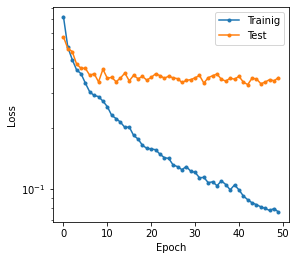

CPU times: user 12min 14s, sys: 5min 38s, total: 17min 53s
Wall time: 9min 3s


In [176]:
%%time
nb_of_epochs = 50

epoch_training_losses = np.empty(nb_of_epochs)
epoch_test_losses = np.empty(nb_of_epochs)

# Iterate through train set minibatchs
for epoch in tqdm(range(nb_of_epochs)):  
    print('Epoch ' + str(epoch))
    # Train
    training_losses = list()
    for sample in tqdm(train_data_loader, desc='Training', ascii=True):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = torch.transpose(torch.stack([sample[key] for key in keys_input]), 0, 1)
        y = model(x)
        loss = criterion(y, sample['sigma0_delta'].view(batch_size, 1, h, w))
        # Backward pass
        loss.backward()
        optimizer.step()
        training_losses = np.append(training_losses, loss.detach().numpy())
    epoch_training_losses[epoch] = np.mean(training_losses)
    # Test
    with torch.no_grad():
        test_losses = list()
        for sample in tqdm(test_data_loader, desc='Testing', ascii=True):
            # Forward pass
            x = torch.transpose(torch.stack([sample[key] for key in keys_input]), 0, 1)
            y = model(x)

            loss = criterion(y, sample['sigma0_delta'].view(batch_size, 1, h, w))
            test_losses = np.append(test_losses, loss.detach().numpy())
        epoch_test_losses[epoch] = np.mean(test_losses)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3.5), constrained_layout=True)
    
    ax.plot(epoch_training_losses[0:epoch+1], '.-', label='Trainig')
    ax.plot(epoch_test_losses[0:epoch+1], '.-', label='Test')
    ax.set(yscale='log', xlabel='Epoch', ylabel='Loss')
    ax.legend()
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    plt.show()

In [181]:
sample = test_data_iterator.next()

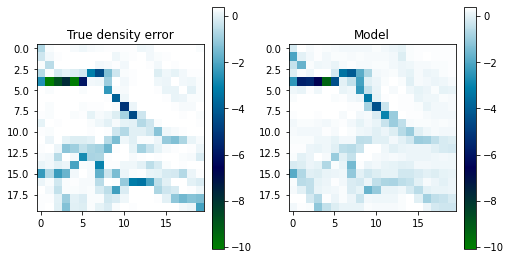

In [182]:
index_in_batch = 6

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(7,3.5), constrained_layout=True)
img1 = ax[0].imshow(np.squeeze(sample['sigma0_delta'][index_in_batch].numpy()), cmap='ocean')
fig.colorbar(img1, ax=ax[0])
cmax = img1.colorbar.vmax
img2 = ax[1].imshow(np.squeeze(model(torch.transpose(torch.stack([sample[key] for key in keys_input]), 0, 1)).detach().numpy()[index_in_batch]), cmap='ocean', vmin=img1.colorbar.vmin, vmax=img1.colorbar.vmax)
ax[0].set(title='True density error')
ax[1].set(title='Model')
fig.colorbar(img2, ax=ax[1])